In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential
from keras.layers import Layer, Flatten, Dense, Input, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import plot_model

In [2]:
from sklearn.model_selection import train_test_split
from keras import backend as K

In [4]:
pos_df = pd.read_csv("pos_aug.csv")

In [5]:
neg_df = pd.read_csv("neg_aug.csv")

In [6]:
pos_df["label"] = 1
neg_df["label"] = 0

In [7]:
neg_df = neg_df.sample(n =2240)

In [8]:
df = pd.concat([pos_df, neg_df])
# shuffle 
df = df.sample(frac=1).reset_index(drop=True)

In [17]:
image1=tf.data.Dataset.from_tensor_slices('Data/'+df['image1'])
image2=tf.data.Dataset.from_tensor_slices('Data/'+df['image2'])
labels=tf.data.Dataset.from_tensor_slices(df['label'])

In [10]:
import os
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

# tensorboard 

In [19]:
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, size = (224,224))
    image = image/255.0
    return image

In [20]:
image1_dataset = image1.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image2_dataset = image2.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [21]:
batch_size = 32
image1_dataset_features = image1_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
image2_dataset_features = image2_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
labels=labels.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
len(labels)

1710

In [23]:
def format_data(image1, image2, labels):
    return (image1, image2), labels
ds = tf.data.Dataset.zip((image1_dataset_features, image2_dataset_features, labels)).map(format_data)



In [24]:
images,labels=ds.as_numpy_iterator().next()
# X, y = dataset.as_numpy_iterator().next() --> 1st image
# X, y = dataset.as_numpy_iterator().next() --> 2nd image
image1,image2=images

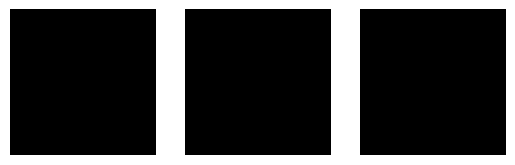

In [25]:
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(image2[i].astype('uint8'))
  plt.axis('off')

In [26]:
# no. of batches
total_batches=tf.data.experimental.cardinality(ds)
print(total_batches)

tf.Tensor(1710, shape=(), dtype=int64)


In [27]:

val_ds=ds.take(total_batches//4)  # 25%
train_ds=ds.skip(total_batches//4) # baki 75%


In [28]:
total_train_batches=tf.data.experimental.cardinality(train_ds)
total_train_batches

<tf.Tensor: shape=(), dtype=int64, numpy=1283>

In [29]:
total_val_batches=tf.data.experimental.cardinality(val_ds)
total_val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=427>

In [30]:
test_ds=val_ds.take(total_val_batches//5)
val_ds=val_ds.skip(total_val_batches//5)

In [31]:
from keras import layers,models
from keras.applications import VGG16
input_shape=(224,224,3)

In [32]:
def vgg16_feature_extractor(input_shape):
    # Create VGG16 base model
    base_model = VGG16(include_top=False, input_shape=input_shape,weights='imagenet')

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output of the base model
    output = base_model.output

    # Flatten the output feature vectors
    output = layers.GlobalAveragePooling2D()(output)

    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)

    return model

In [33]:

def build_siamese_vgg16(input_shape):
    # Define the input layer for the first image
    input_a = layers.Input(shape=input_shape, name='input_a')
    # Define the input layer for the second image
    input_b = layers.Input(shape=input_shape, name='input_b')

    # Define the VGG16 model (excluding the top layers)
    feature_extractor = vgg16_feature_extractor(input_shape)


    # Get the output feature vectors from the base model for both inputs
    feature_vector_a = feature_extractor(input_a)
    feature_vector_b = feature_extractor(input_b)


    # Distance calculation
    distance = layers.Lambda(lambda x: K.abs(x[0] - x[1]), name='distance')([feature_vector_a, feature_vector_b])

    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='output')(distance)

    # Create the Siamese model
    siamese_model = models.Model(inputs=[input_a, input_b], outputs=output, name='siamese_vgg16')

    return siamese_model

# Set the input shape for the VGG16 model
input_shape = (224, 224, 3)

# Build the Siamese VGG16 twins model

siamese_vgg16 = build_siamese_vgg16(input_shape)

# Compile the model with contrastive loss


# Display the model summary
siamese_vgg16.summary()

Model: "siamese_vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_b (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 512)          14714688    ['input_a[0][0]',                
                                                                  'input_b[0][0]']    

In [34]:
tf.keras.utils.plot_model(siamese_vgg16,show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
from keras.losses import binary_crossentropy

# num_epochs = 10
learning_rate = 0.001

siamese_vgg16.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                      loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics = ["accuracy"])
# Fit the model using generators
history = siamese_vgg16.fit(train_ds,
                    epochs=1,
                    validation_data=val_ds,
                    shuffle=True
                  )

C:\pragati\sampleone\env\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 134/1283 [==>...........................] - ETA: 3:20:37 - loss: 0.3367 - accuracy: 0.9212

In [ ]:
images,labels=test_ds.as_numpy_iterator().next()
image1,image2=images

In [ ]:
predictions=siamese_vgg16.predict_on_batch(images)

In [ ]:
predictions=tf.where(predictions<0.5,0,1)

In [ ]:
predictions

'\ncheckpoint_dir = "/content/drive/MyDrive/iris_checkpoints"\n# checkpoint_path = os.path.join(checkpoint_dir, "epoch_{epoch:02d}")\n# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n #   filepath=checkpoint_path,\n    save_weights_only=True,\n    monitor=\'val_accuracy\',\n    save_best_only=True,\n    verbose=1\n)\n'

In [ ]:
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.imshow(image1[i].astype('uint8'))
  plt.subplot(3,2,2*i+1)
  plt.imshow(image2[i].astype('uint8'))

  true_label=labels[i]
  predicted_label=predictions[i]
  plt.title(f'prediction:{predicted_label}\n true:{true_label}')

In [ ]:
epochs=10
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

,image1,image2,label
1052,106_1.bmp,106_4.bmp,1
2076,208_2.bmp,208_5.bmp,1
150,016_1.bmp,016_2.bmp,1
779,078_4.bmp,078_5.bmp,1
1308,131_3.bmp,131_5.bmp,1
...,...,...,...
2451,123_3.bmp,069_4.bmp,0
3389,163_3.bmp,200_2.bmp,0
20224,179_2.bmp,039_1.bmp,0
12043,094_3.bmp,170_2.bmp,0


In [ ]:
siamese_vgg16.save('siamese_vgg16.h5')

,image1,image2,label
1570,158_1.bmp,158_2.bmp,1
1308,131_3.bmp,131_5.bmp,1
17546,123_1.bmp,019_2.bmp,0
579,058_4.bmp,058_5.bmp,1
1150,116_1.bmp,116_2.bmp,1
...,...,...,...
6670,119_4.bmp,121_2.bmp,0
1687,169_3.bmp,169_4.bmp,1
1655,108_4.bmp,092_1.bmp,0
3613,015_2.bmp,040_5.bmp,0


In [ ]:
next(test)

([array(['040_2.bmp', '003_1.bmp', '155_1.bmp', '203_1.bmp'], dtype=object),
  array(['040_3.bmp', '003_5.bmp', '113_2.bmp', '207_3.bmp'], dtype=object)],
 array([1, 1, 0, 0]))

Epoch 1/10
112/112 [==============================] - 558s 5s/step - loss: 0.1820 - accuracy: 0.2620 - val_loss: 0.1166 - val_accuracy: 0.1328
Epoch 2/10
112/112 [==============================] - 121s 1s/step - loss: 0.1000 - accuracy: 0.1169 - val_loss: 0.0707 - val_accuracy: 0.0848
Epoch 3/10
112/112 [==============================] - 121s 1s/step - loss: 0.0671 - accuracy: 0.0792 - val_loss: 0.1337 - val_accuracy: 0.1518
Epoch 4/10
112/112 [==============================] - 125s 1s/step - loss: 0.3076 - accuracy: 0.3094 - val_loss: 0.2240 - val_accuracy: 0.2243
Epoch 5/10
112/112 [==============================] - 123s 1s/step - loss: 0.2097 - accuracy: 0.2098 - val_loss: 0.2180 - val_accuracy: 0.2188
Epoch 6/10
112/112 [==============================] - 119s 1s/step - loss: 0.2156 - accuracy: 0.2157 - val_loss: 0.1961 - val_accuracy: 0.1964
Epoch 7/10
 55/112 [=============>................] - ETA: 44s - loss: 0.2146 - accuracy: 0.2148

KeyboardInterrupt: 

,image1,image2,label
21241,018_5.bmp,003_2.bmp,0
12425,101_5.bmp,151_4.bmp,0
5853,023_1.bmp,067_2.bmp,0
13922,064_1.bmp,150_3.bmp,0
5671,119_5.bmp,185_3.bmp,0


TensorShape([224, 224, 1])

TensorShape([224, 224, 1])

1/1 [==============================] - 0s 55ms/step
[[0.49916568]]


array([[0.49916568]], dtype=float32)